# More Feature Engineering

From the previous iteration, we find out that we have some outliers which needs to be removed. We also come to know that 'Overall Qual', 'Gr Liv Area',  'Total Bsmt SF', 'Garage Finish', 'Fireplace Qu', 'Mas Vnr Area', 'Age When Sold', 'Age After Remodeled When Sold' are among the top predictors of sale price. We had removed Garage Finish from the list as i has the lowest coefficient to sale price amongst the rest of the predictors

In this iteration we will manually compute some interactions deemed to be related with the top predictors, perform feature selection and feature engineering again and determine if we are able to come out with a better model to be submitted to Kaggle for evaluation

Content:
- [Import Library and Load Dataset](#Import-Library-and-Load-Dataset)
- [Functions](#Functions)
- [Remove Outliers](#Remove-Outliers)
- [Create Columns and Interaction Terms](#Create-Columns-and-Interaction-Terms)
- [Feature Selection](#Feature-Selection)
- [Scatter Plots](#Scatter-Plots)
- [Histograms](#Histograms)
- [Model Prep](#Model-Prep)
- [Scaling](#Scaling)
- [Instantiate Models and Cross Validation](#Instantiate-Models-and-Cross-Validation)
- [Model Fitting and Evaluation](#Model-Fitting-and-Evaluation)
- [Model 1 - Submission to Kaggle](#Model-1-Submission-to-Kaggle)


## Import Library and Load Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn import metrics
from scipy.stats import norm

In [2]:
train = pd.read_csv('../datasets/train_featured.csv')
test = pd.read_csv('../datasets/test_featured.csv')

## Functions

We will be using quite a number of functions created previously and load them here in this section

In [3]:
# Function to get top correlation and plot heatmap

def top_corr_and_plot(dataframe, target):
    top_corr_list = []
    cor = dataframe.corr()
    cor_target = (cor[target])
    pos_corr = cor_target[cor_target>0.55].sort_values(ascending = False)
    neg_corr = cor_target[cor_target < -0.55].sort_values()    
    
    for i in pos_corr.index:
        top_corr_list.append(i)
    for j in neg_corr.index:
        top_corr_list.append(j)
    

    
    # plot heatmap with top correlation
    plt.figure(figsize = (18, 18)) # plot figure should always be on top
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(dataframe[top_corr_list].corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    plt.title('Correlation Heat Map')
    ax = sns.heatmap(dataframe[top_corr_list].corr(), annot=True, vmin = -1, vmax = 1, linewidth = 0.8, cmap="Blues", cbar=False, mask = mask, square = True);
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylim(19, 1);
    #print(ax.get_ylim())
    
    print('Top correlated columns to sale price are:\n{}'.format(top_corr_list))

In [4]:
# Draw Scatter Plot

def subplot_scatter(dataframe, column_x, column_y):
    nrows = int(np.ceil(len(column_x)/2)) # Makes sure you have enough rows
    #ncols = int(len(column_x))
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (28, 10))
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, (columnx, columny) in enumerate(zip(column_x, column_y)): # Gives us an index value to get into all our lists
        sns.regplot(x = columnx, y = columny, data = dataframe, ax = ax[i], color ='b')
        ax[i].set_title('Scatter of {} and {}'.format(column_x[i], column_y[i]), fontsize = 25)
        ax[i].set_xlabel(column_x[i].replace('_', ' ').title(), fontsize = 25)
        ax[i].set_ylabel(column_y[i].replace('_', ' ').title(), fontsize = 25)
        #ax[i].legend(column_x, loc = 'upper right')
        ax[i].grid(axis = 'y', alpha = 0.5) # set grid line, alpha is transparency
        fig.tight_layout()

In [5]:
# Draw Histogram

def subplot_histograms(dataframe, list_of_columns, ylabel = 'Probability Density Function'):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (28, 10)) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.distplot(dataframe[column], ax = ax[i], bins = 10, fit = norm, kde = True)
        mean = dataframe[column].mean()
        ax[i].set_title('{} Distribution'.format(list_of_columns[i]), fontsize = 25)
        ax[i].set_xlabel(list_of_columns[i], fontsize = 25)
        ax[i].set_ylabel(ylabel, fontsize = 25)
        ax[i].axvline(mean, color = 'r')
        ax[i].grid(axis = 'y', alpha = 0.5) # set grid line, alpha is transparency
        fig.tight_layout()

In [6]:
# a function to get the score for linear regression, lasso and ridge

def score(X_train, y_train):
    lr = LinearRegression()
    lasso = LassoCV(cv = 3)
    ridge = RidgeCV()
    
    lr_scores = cross_val_score(lr, X_train, y_train, cv=5)
    lr_scores.mean()
    print('Linear Regression mean score is: {}'.format(lr_scores.mean()))
    
    lasso_scores = cross_val_score(lasso, X_train, y_train, cv=5)
    lasso_scores.mean()
    print('Lasso mean score is: {}'.format(lasso_scores.mean()))
    
    ridge_scores = cross_val_score(ridge, X_train, y_train, cv=5)
    ridge_scores.mean()
    print('Ridge mean score is: {}'.format(ridge_scores.mean()))
    

In [7]:
# Function to plot Coefficient

def plot_ridge_coref(coef):    

    coefficent_series = pd.Series(coef, index=features)

    plt.figure(1, figsize = (12, 5))
    plt.title('Ridge Coefficient', fontsize = 20)
    plt.xlabel('Price', fontsize = 15)
    plt.ylabel('Features', fontsize = 15)
    plt.barh(coefficent_series.index, coefficent_series.values)
    

In [8]:
def plot_pred_residual_scatter(pred, residuals):    
    plt.figure(3, figsize = (14.65, 5))
    plt.title('Prediction and Residual Plot', fontsize = 20)
    plt.xlabel('Predicted Price', fontsize = 15)
    plt.ylabel('Residual', fontsize = 15)
    plt.scatter(pred, residuals)
    plt.axhline(0, color='r')

In [9]:
def plot_pred_actual_scatter(pred, y_test):    
    plt.figure(2, figsize = (14.65, 5))
    plt.title('Predict and Actual Scatter Plot', fontsize = 20)
    plt.xlabel('Predicted Price', fontsize = 15)
    plt.ylabel('Actual Price', fontsize = 15)
    sns.regplot(pred, y_test);

## Remove Outliers

- From the previous iteration we see that there are 2 outliers, where Gr Liv Area is more than 4000. 
- There is also one outlier where Mas Vnr Area is more than 1400. We will remove them for both train and test

In [10]:
train.drop(train.loc[train['Gr Liv Area'] > 4000].index, inplace = True)

In [11]:
train.drop(train.loc[train['Mas Vnr Area'] > 1400 ].index, inplace = True)

## Create Columns and Interaction Terms

Size and quality are good predictors, columns which shows such features more prominently will be created.
After finding out the top predictors from previous iteration, interaction terms can also be created with categories that are deemed to be related to the predictors

### Create Columns

Overall Quality and Size are important factors in price. High Quality Finish Area column is created. This column contains the value of high quality area

In [12]:
train['High Qual Fin Area'] = train['Gr Liv Area'] - train['Low Qual Fin SF']
test['High Qual Fin Area'] = test['Gr Liv Area'] - train['Low Qual Fin SF']

### Interaction Terms

Garage Area is one of the top predictors, features related to Garage are interacted to a new column

In [13]:
train['Garage Rating'] = train['Garage Area'] * train['Garage Qual'] * train['Garage Cond']* train['Garage Finish']
test['Garage Rating'] = test['Garage Area'] * test['Garage Qual'] * test['Garage Cond'] * test['Garage Finish']

Basement is one of the top predictors, features related to basement are interacted to a new column

In [14]:
train['Basement Overall'] = train['Total Bsmt SF'] * train['Bsmt Qual'] * train['Bsmt Cond'] * train['Bsmt Exposure']
test['Basement Overall'] = test['Total Bsmt SF'] * test['Bsmt Qual'] * test['Bsmt Cond'] * test['Bsmt Exposure']

Fireplaces is also one of the top predictor, features related to fireplaces are interacted to a new column

In [15]:
train['Fireplace Overall'] = train['Fireplace Qu'] * train['Fireplaces']
test['Fireplace Overall'] = test['Fireplace Qu'] * test['Fireplaces']

Overall Quality and Lot Area which is the size of the property is interacted together

In [16]:
train['Lot Size Overall Qual'] = train['Overall Qual'] * train['Lot Area']
test['Lot Size Overall Qual'] = test['Overall Qual'] * test['Lot Area'] 

Age When Sold and Sale Type was interacted to create a another column 

In [17]:
train['Sale Overall Condition'] = train['Age When Sold'] * train['Sale Type']
test['Sale Overall Condition'] = test['Age When Sold'] * test['Sale Type']

## Feature Selection

Top correlated columns to sale price are:
['SalePrice', 'Overall Qual', 'Garage Rating', 'High Qual Fin Area', 'Gr Liv Area', 'Exter Qual', 'Kitchen Qual', 'Basement Overall', 'Total Bsmt SF', 'Garage Area', '1st Flr SF', 'Bsmt Qual', 'Year Built', 'Garage Finish', 'Lot Size Overall Qual', 'Year Remod/Add', 'Age When Sold', 'Sale Overall Condition', 'Age After Remodeled When Sold']


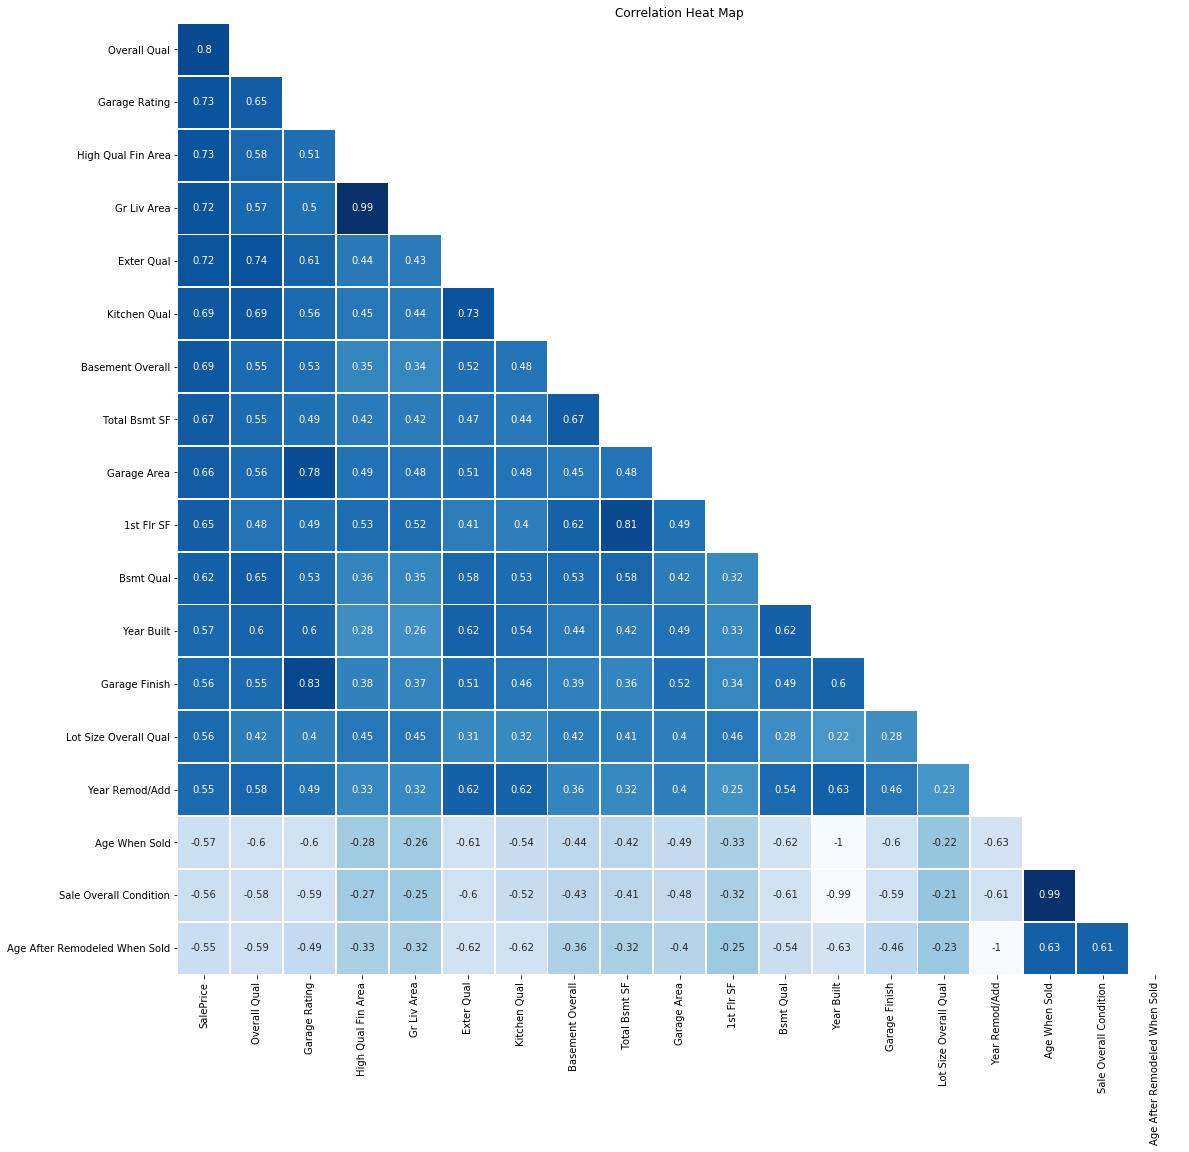

In [18]:
top_corr_and_plot(train, 'SalePrice')

We shall only include independent variables that are not highly correlated with each other. Should 2 independent variables be more highly correlated than they are correlated to the Sale Price, we will keep the one that is more correlated to Sales Price.

With that we have refined our column list and they are listed below

In [19]:
filtered = train[['SalePrice', 'Overall Qual', 'Garage Rating', 'High Qual Fin Area', 'Kitchen Qual', 'Basement Overall', 
                  '1st Flr SF', 'Lot Size Overall Qual', 'Age When Sold', 'Sale Overall Condition']]

## Scatter Plots

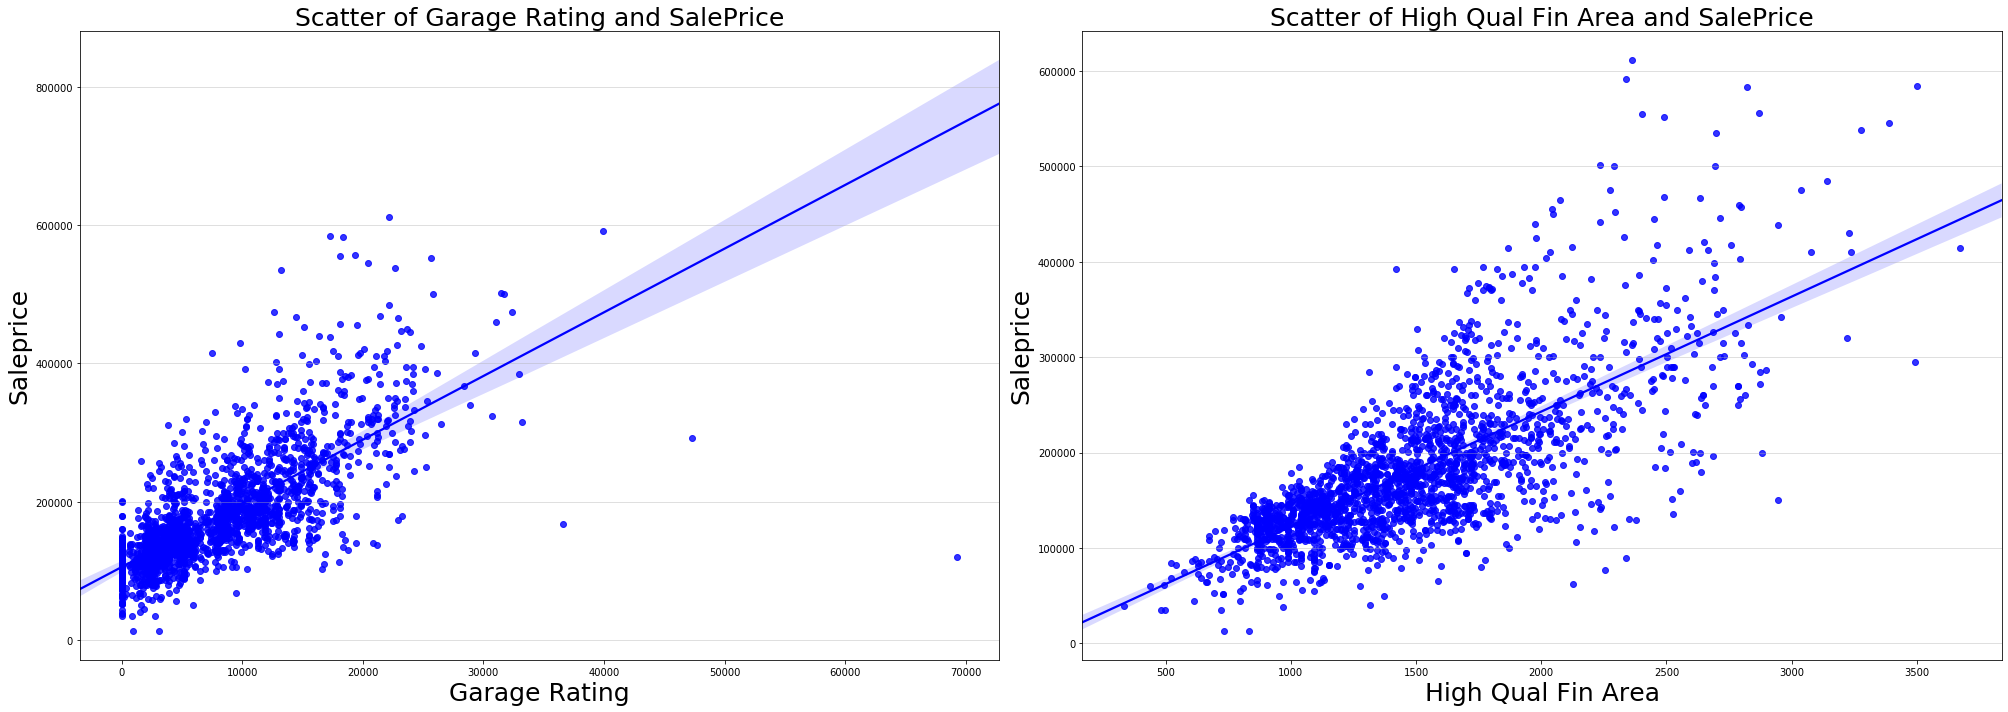

In [20]:
target = 'SalePrice'
x = ['Garage Rating', 'High Qual Fin Area']
y = [target for i in range(len(x))]
subplot_scatter(filtered, x, y)

- Garage rating and sale price are postively correlated
- Garage rating we can see that there is an outlier of more than 65000
- High Qual Fin Area and Sale Price are positively correlated

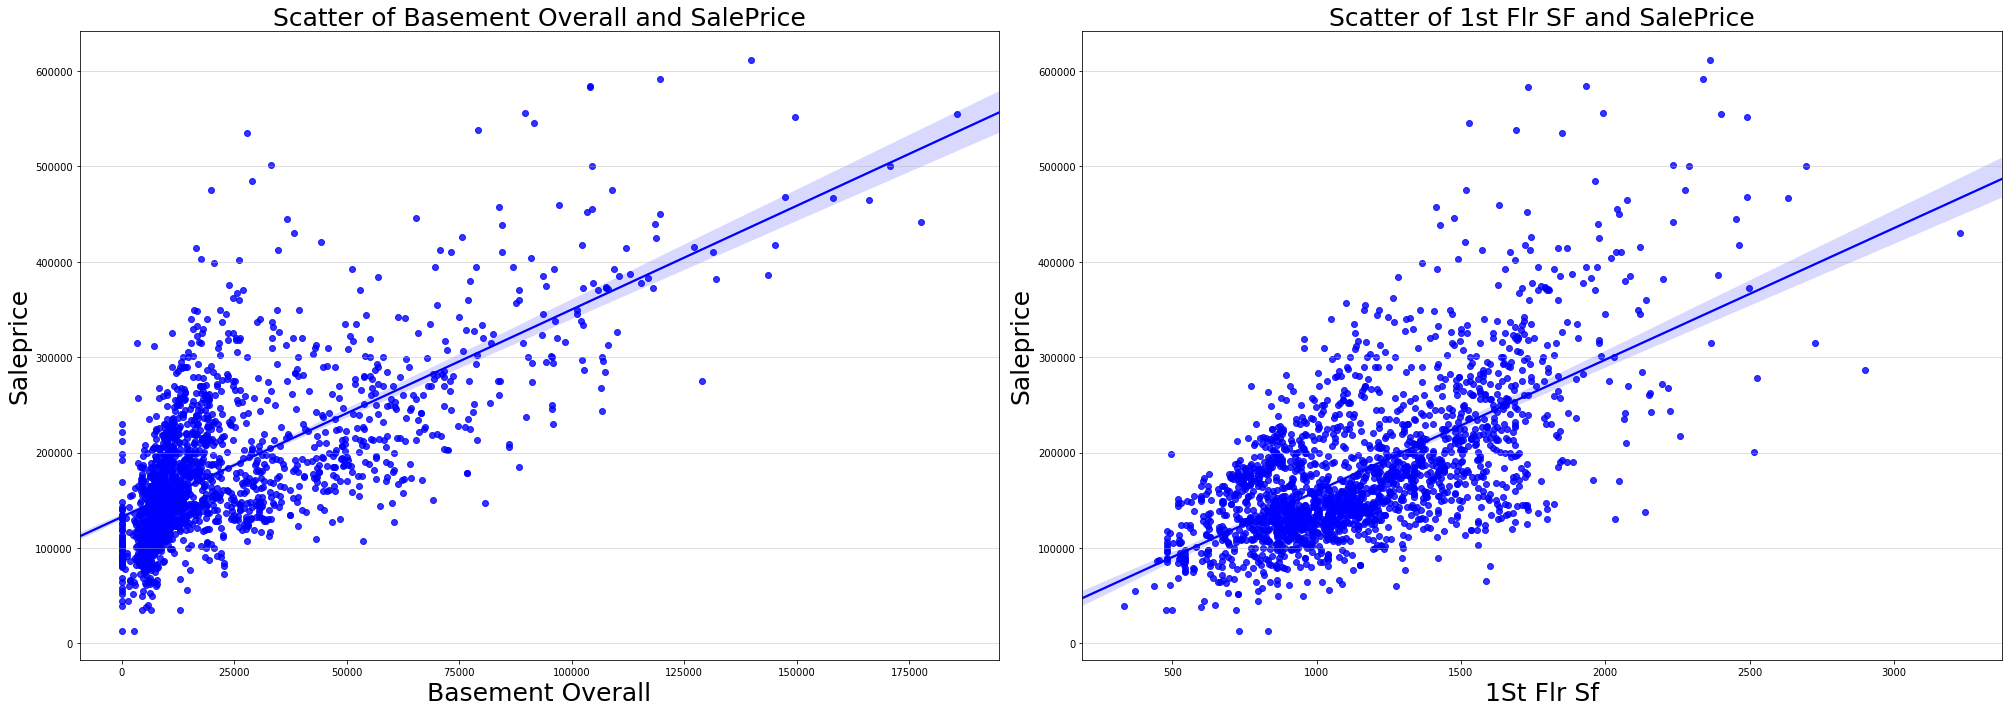

In [21]:
target = 'SalePrice'
x = ['Basement Overall', '1st Flr SF']
y = [target for i in range(len(x))]
subplot_scatter(filtered, x, y)

- Basement Overall and Sale Price are positively correlated
- Basement Overall have quite a number of zeros, they are deemed to be for properties without any basement 
- 1st Flr SF and sale price are positively correlated
- 1st Flr SF seems do not display any outliers

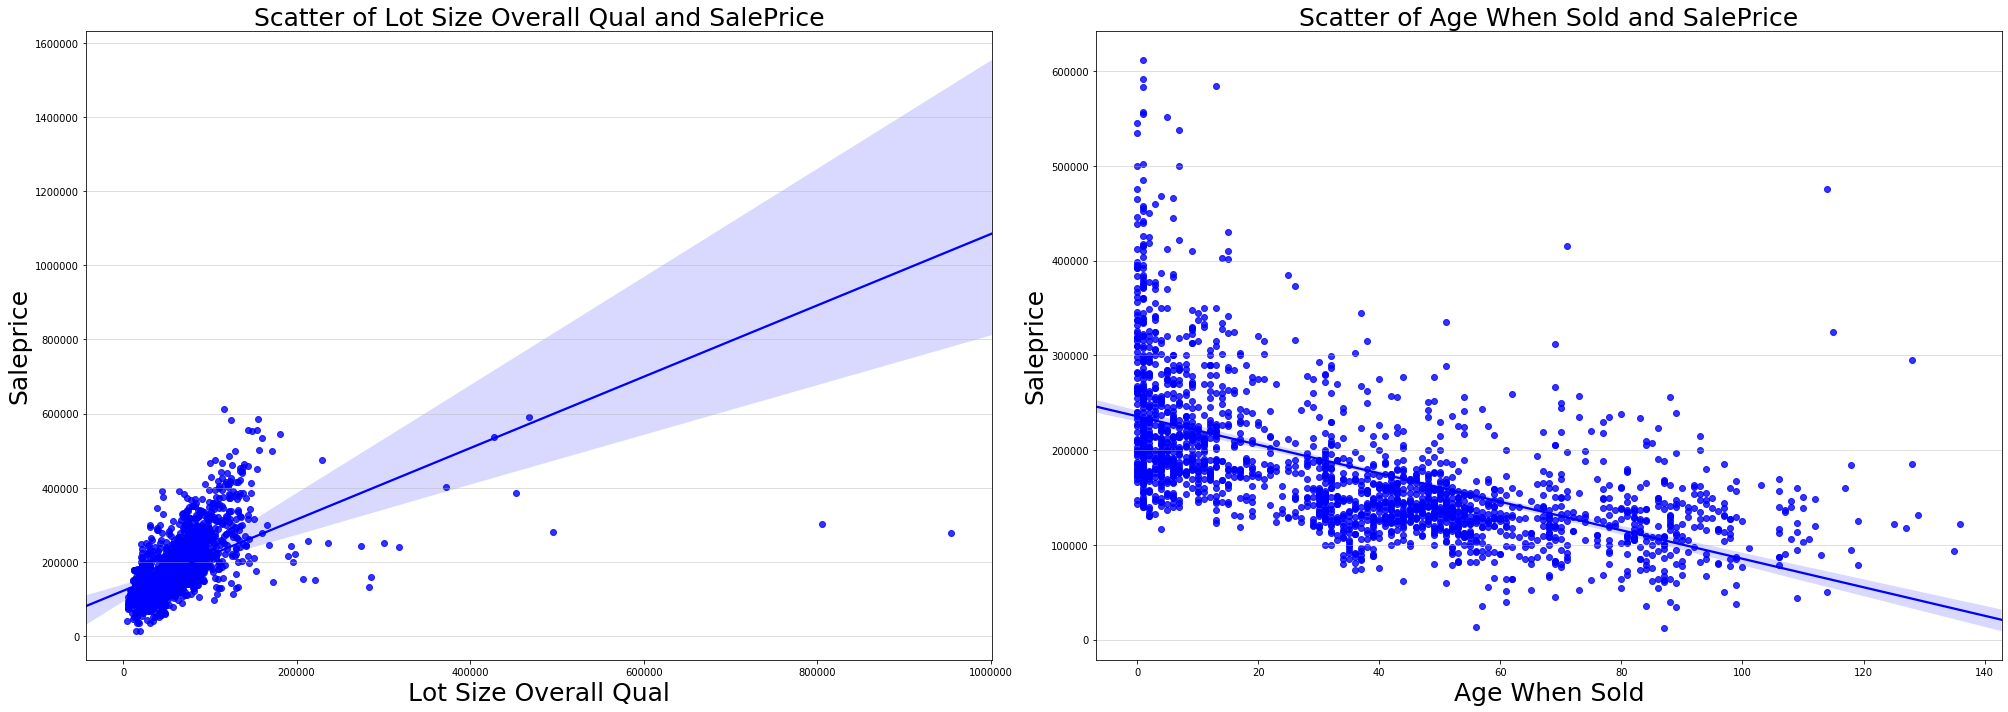

In [22]:
target = 'SalePrice'
x = ['Lot Size Overall Qual', 'Age When Sold']
y = [target for i in range(len(x))]
subplot_scatter(filtered, x, y)

- Lot size Overall Qual and Sale Price are positively correlated
- Lot size Overall Qual have 2 outliers over 78000
- Age When Sold and Sale Price are negatively correlated
- Age When Sold do not display some outliers

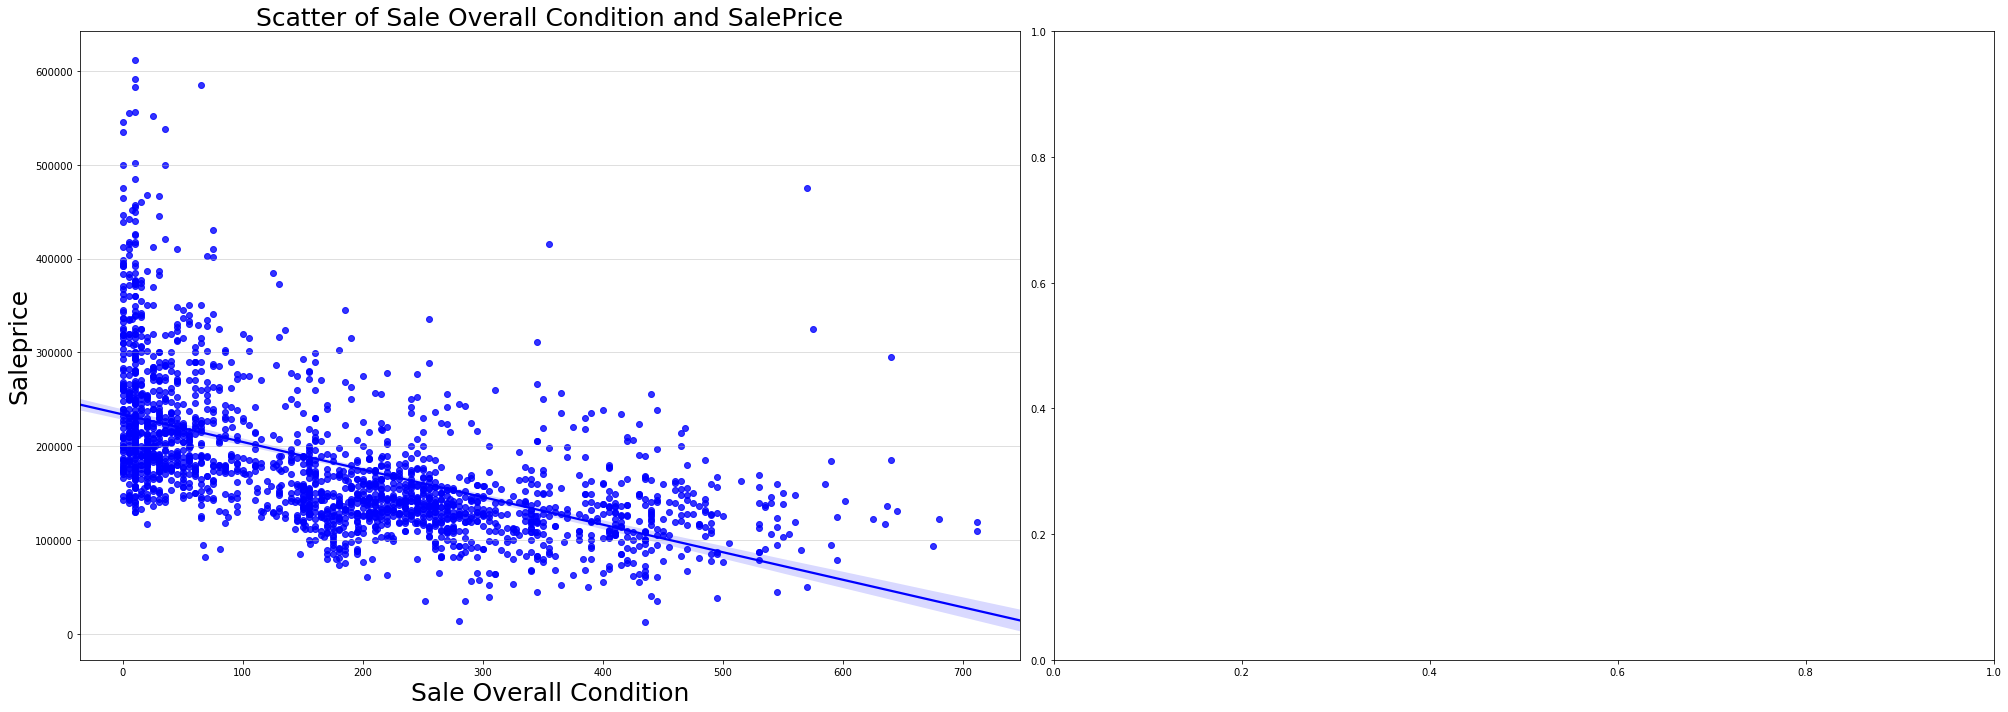

In [23]:
target = 'SalePrice'
x = ['Sale Overall Condition']
y = [target for i in range(len(x))]
subplot_scatter(filtered, x, y)

- Sale price and sale overall condition is negatively correlated
- There are no outliers for sale overall condition

## Histograms

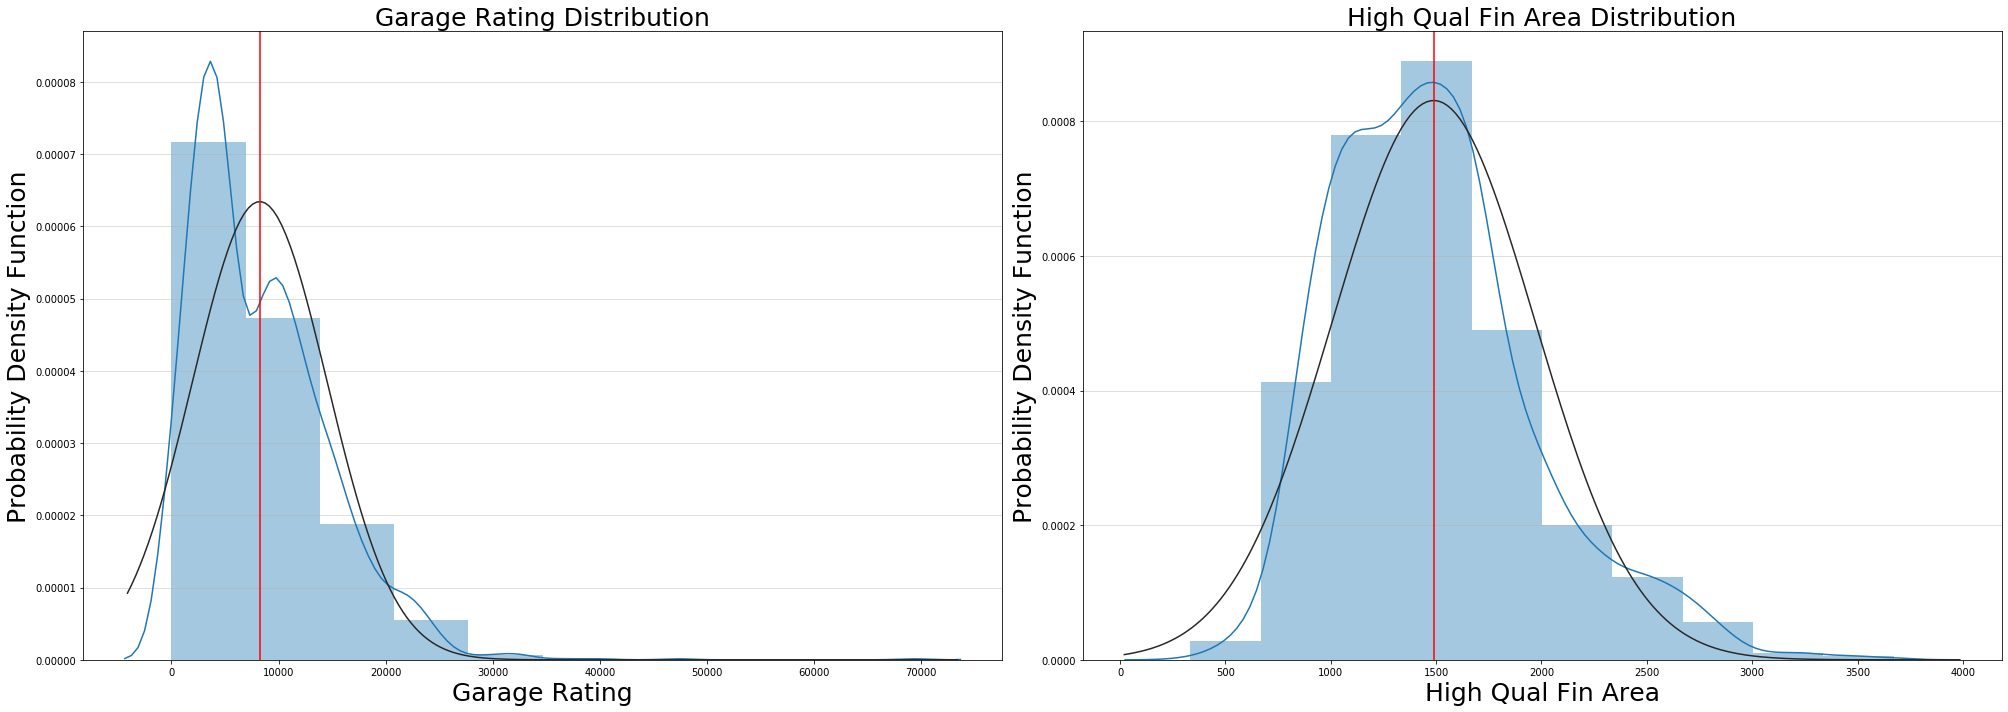

In [24]:
list_of_columns = ['Garage Rating', 'High Qual Fin Area']

subplot_histograms(filtered, list_of_columns)

- Garage Rating is skewed to the left, its mean is quite close to the mode. We can see that most of the data has a low garage rating. We can also see some outliers which is consistent with what we see in the scatter plot
- High Quality Fin Area's distribution is quite normal, its mode is near to the mean and from the graph more than 68% of the data falls within 1 standard deviation

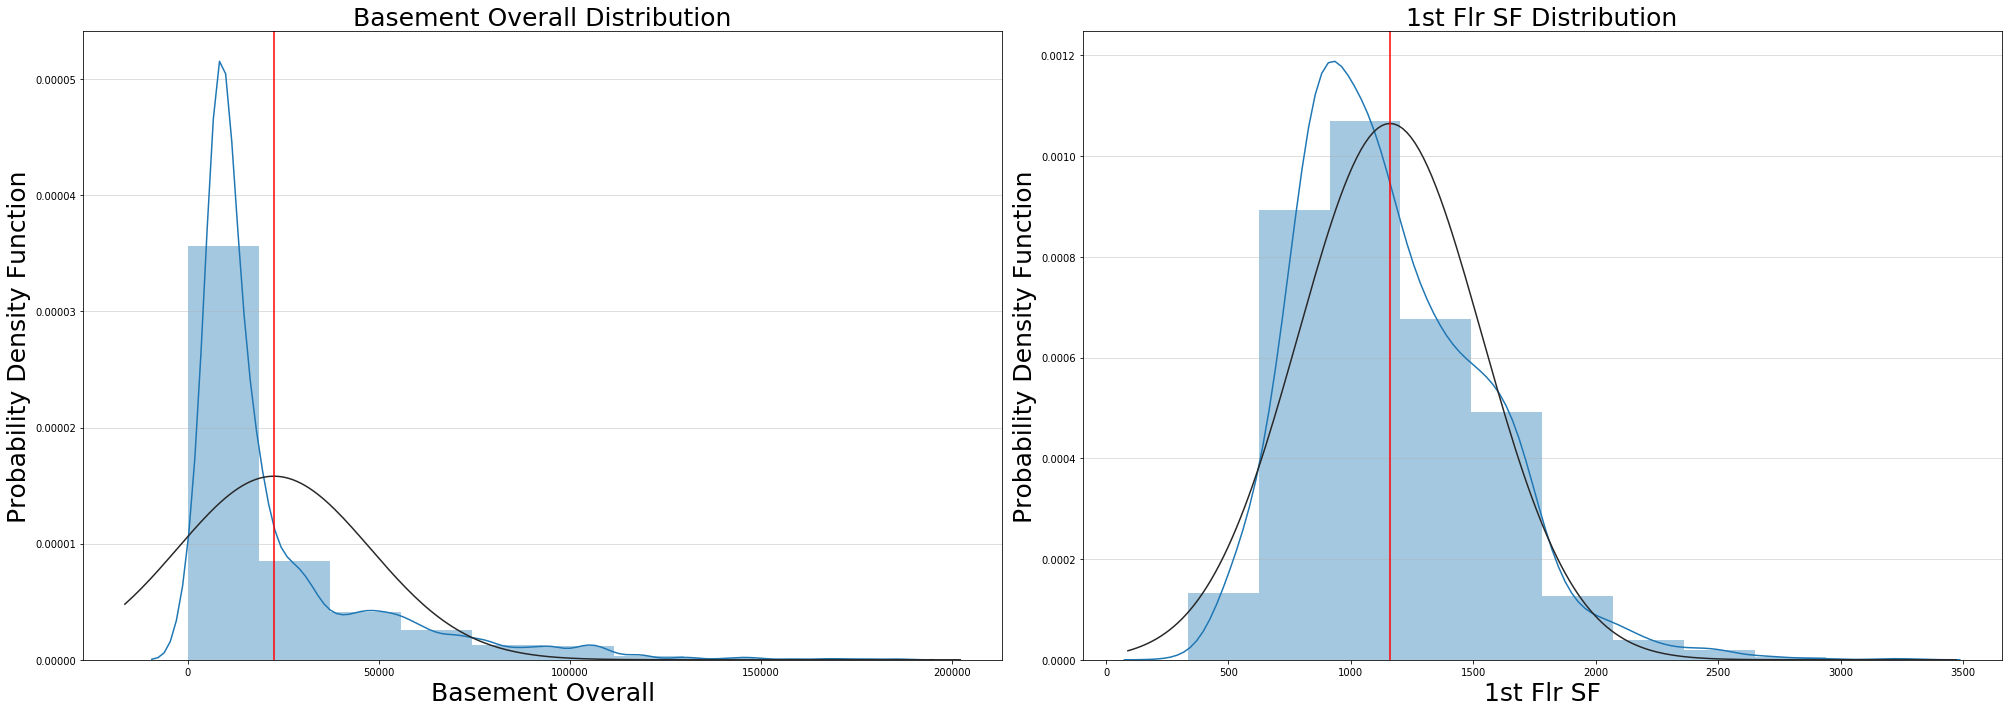

In [25]:
list_of_columns = ['Basement Overall', '1st Flr SF']

subplot_histograms(filtered, list_of_columns)

- Basement Overall is heavily skewed to the right, the mode is not near the mean and most of the data falls towards the left of the mean
- 1st Flr SF's distribution slightly skewed to the right, its mode is still quite near to the mean

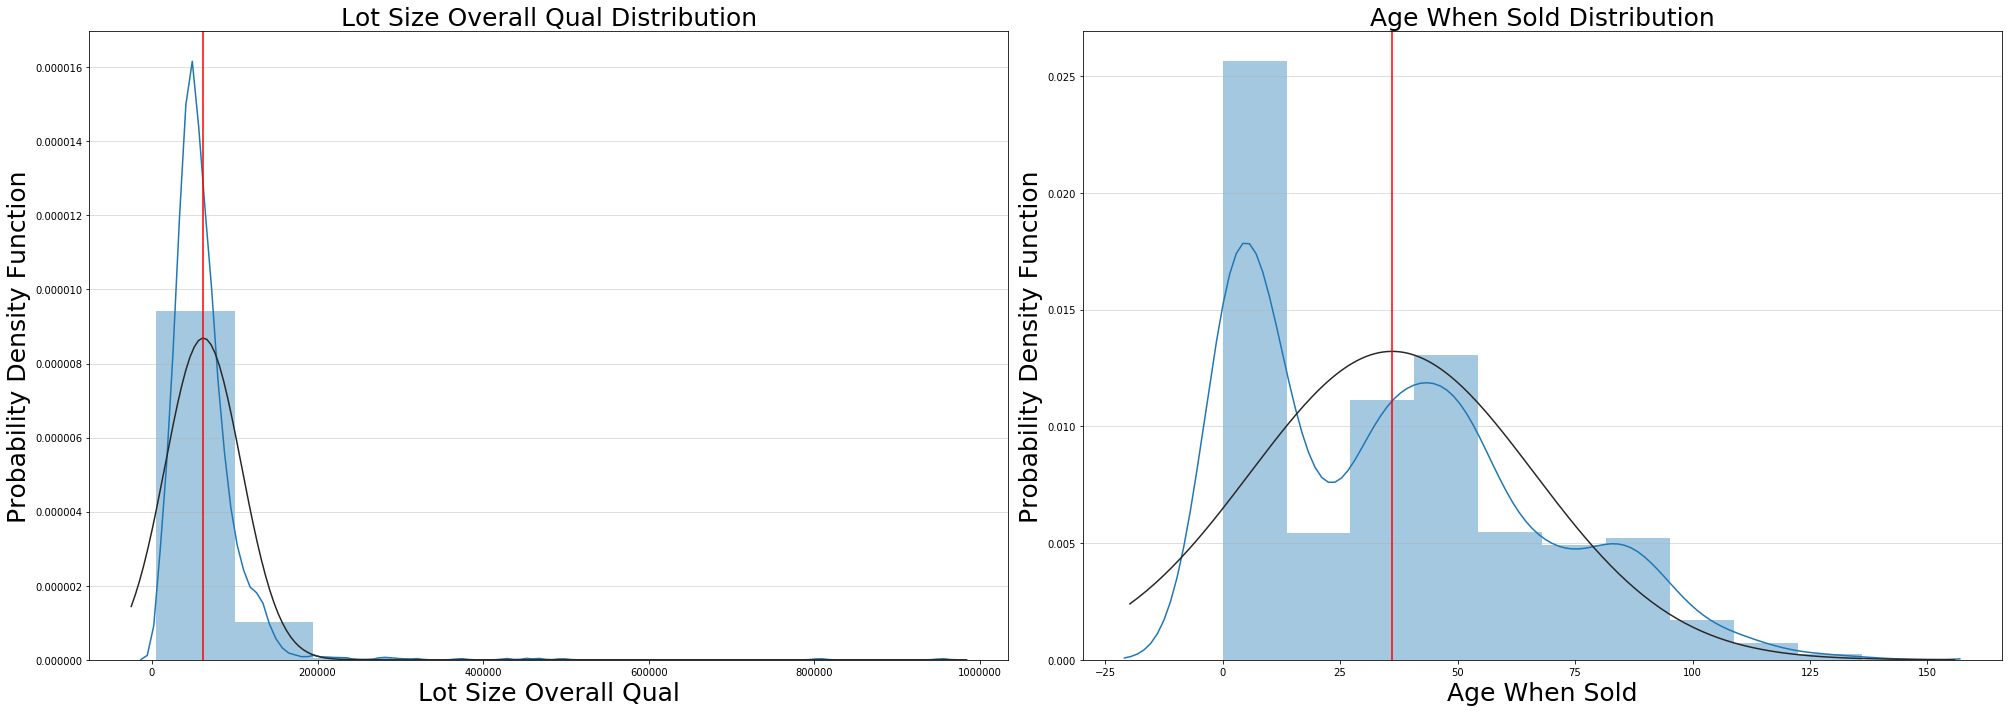

In [26]:
list_of_columns = ['Lot Size Overall Qual', 'Age When Sold']

subplot_histograms(filtered, list_of_columns)

- Lot Size Overall Qual is skewed to the right and there are some outliers. This tallies with what was displayed n the scatter plot
- Age when sold's distribution plot is not normal, its mean is not near the mode

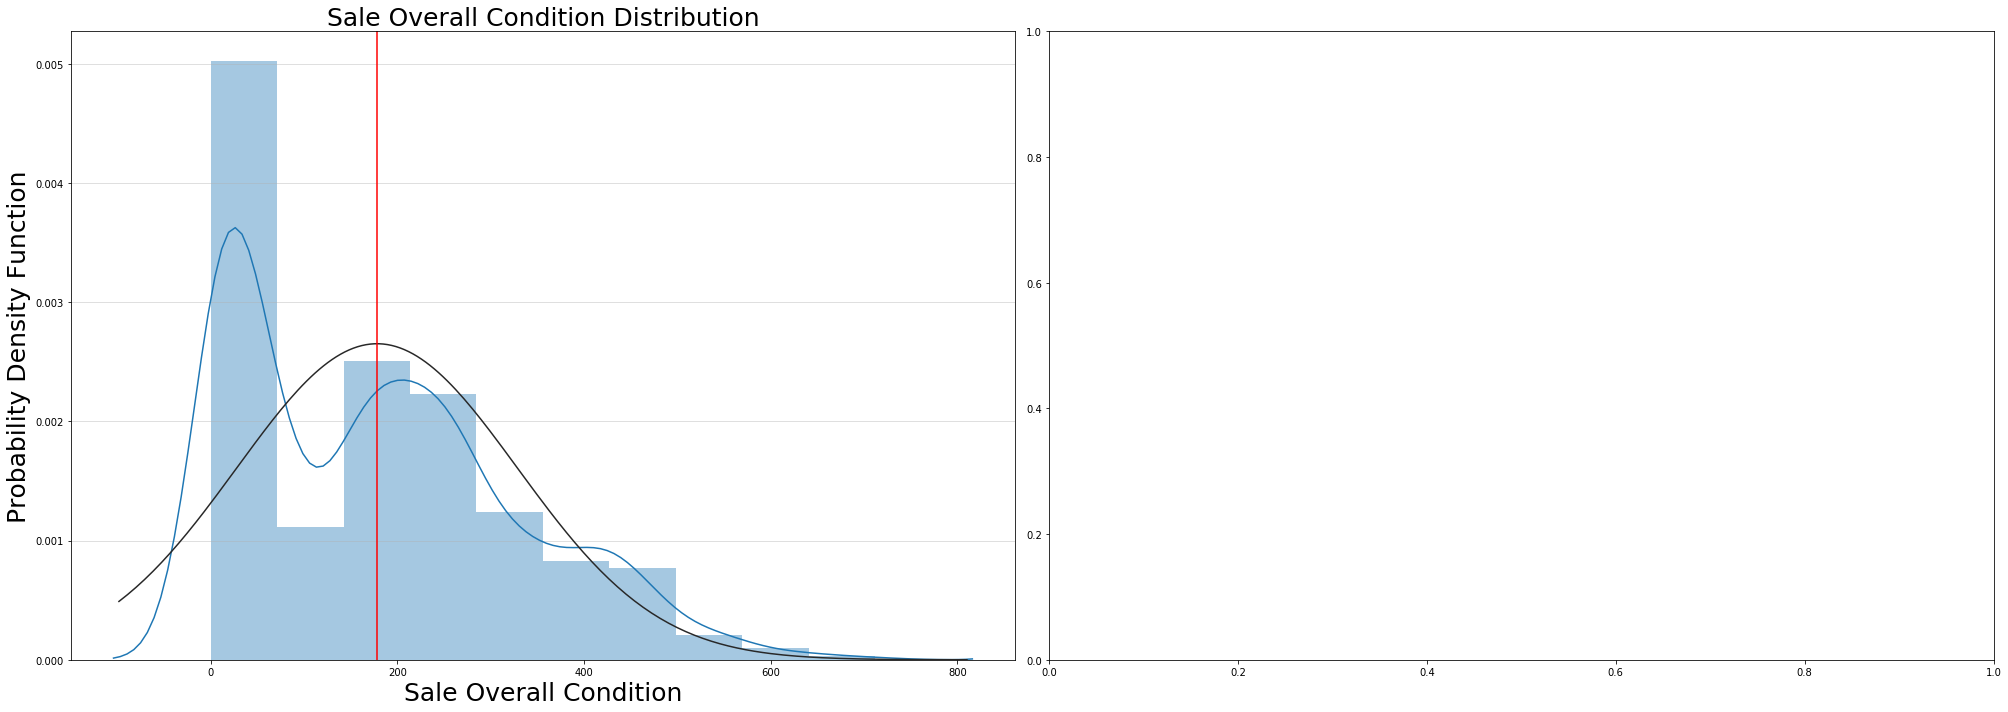

In [27]:
list_of_columns = ['Sale Overall Condition']

subplot_histograms(filtered, list_of_columns)

- Sale Overall Condition's distribution plot is not normally distributed and their mean is not near to the mode 

## Model Prep

In [28]:
features = [col for col in filtered.columns if col != 'SalePrice']
X = filtered[features]
y = filtered['SalePrice']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Scaling

In [30]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

## Instantiate Models and Cross Validation

In [31]:
score(X_train, y_train)

Linear Regression mean score is: 0.8750936408251515
Lasso mean score is: 0.8751693328078634
Ridge mean score is: 0.8752794620020508


We can see that Ridge is still the best. We shall use ridge to fit our model and check the score 

## Model Fitting and Evaluation

In [32]:
# Fit the model using ridge

ridge = RidgeCV()
ridge.fit(X_train, y_train)
train_score = ridge.score(X_train, y_train)
test_score = ridge.score(X_test, y_test)
pred = ridge.predict(X_test)
rsme = np.sqrt(metrics.mean_squared_error(pred, y_test))
residuals = y_test - pred
coef = ridge.coef_
print('Train Score is {}'.format(train_score))
print('Test Score is {}'.format(test_score))
print('Root Mean Square Error is {}'.format(train_score))

Train Score is 0.8803429778466639
Test Score is 0.8415424126264156
Root Mean Square Error is 0.8803429778466639


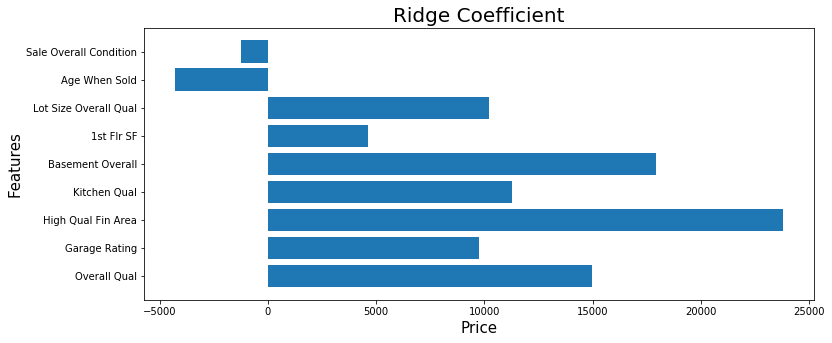

In [33]:
plot_ridge_coref(coef)

From the above coefficient plot:
- 1 unit increase in Sale Overall Condition is equals to around 1000 decrease in Sale Price
- 1 unit increase in Age When Sold is equals to around 4000 decrease in Sale Price
- 1 unit increase in Lot Size Overall Qual is equals to around 10000 increase in Sale Price
- 1 unit increase in 1st Flr SF is equals to around 5000 increase in Sale Price
- 1 unit increase in Basement Overall is equals to around 18000 increase in Sale Price
- 1 unit increase in Kitchen Qual is equals to around 12000 increase in Sale Price
- 1 unit increase in High Qual Fin Area is equals to around 23000 increase in Sale Price
- 1 unit increase in Garage Rating is equals to around 9000 increase in Sale Price
- 1 unit increase in Overall Qual is equals to around 15000 increase in Sale Price

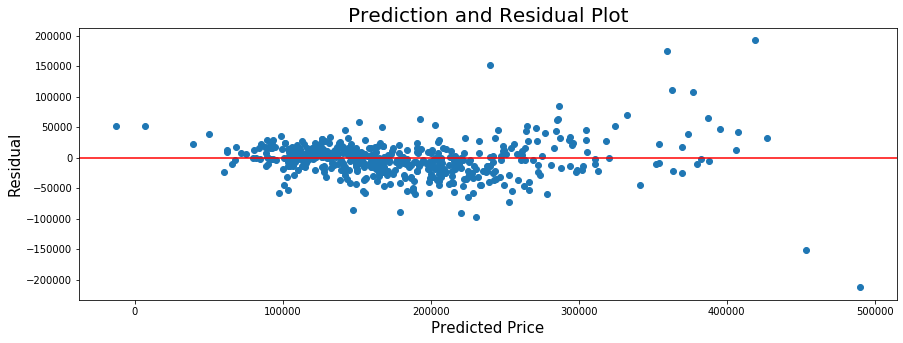

In [34]:
plot_pred_residual_scatter(pred, residuals)

From the above prediction and residual scatter plot, we can see that there is a slight improvement compared to the first iteration.

The points are more heteroscedastic when compared to the first iteration and the heteroscedastic characteristic to not decrease as much when the predicted price increase

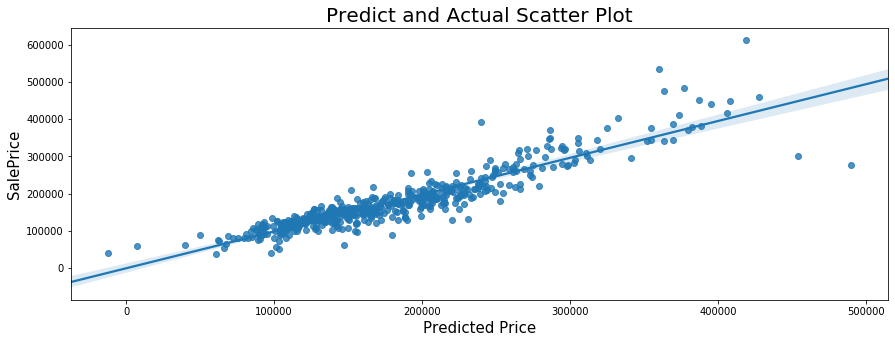

In [35]:
plot_pred_actual_scatter(pred, y_test) 

Similar to the prediction and residual scatter plot, we can see an improvement in the prediction and actual scatter plot. The points are more close to the line when compared to the first iteration.

We will submit this model to kaggle for scoring and perform improvements at the next iteration

## Model 1 Submission to Kaggle

In [36]:
test_selected_features = test[['Overall Qual', 'Garage Rating', 'High Qual Fin Area', 'Kitchen Qual', 'Basement Overall', 
                               '1st Flr SF', 'Lot Size Overall Qual', 'Age When Sold', 'Sale Overall Condition']]

train_selected_features = train [['Overall Qual', 'Garage Rating', 'High Qual Fin Area', 'Kitchen Qual', 'Basement Overall', 
                               '1st Flr SF', 'Lot Size Overall Qual', 'Age When Sold', 'Sale Overall Condition']]

sale_price = train['SalePrice']

In [37]:
ss = StandardScaler()
train_sc = ss.fit_transform(train_selected_features)
test_sc = ss.fit_transform(test_selected_features)
model = RidgeCV()
model.fit(train_sc, sale_price)
prediction = model.predict(test_sc)

In [38]:
answer_dataframe = pd.DataFrame(test['Id'])
answer_dataframe['SalePrice'] = prediction
answer_dataframe.set_index(['Id'], inplace = True)
answer_dataframe.to_csv('../datasets/answer.csv')

In [39]:
train.to_csv('../datasets/train_featured2.csv', index = False)
test.to_csv('../datasets/test_featured2.csv', index = False)

- **Kaggle Public Score is 30596.49672**
- **Kaggle Private Score is 34528.55665**